## 1. Data and core metrics

We start by loading the SkyGeni sales dataset, creating a `won_flag` target, and computing the **baseline win rate**.
This gives us the foundation for segment drivers, risk bands, and stalled pipeline metrics.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Load data
df = pd.read_csv("../data/skygeni_sales_data.csv")  # adjust path if needed

# 2. Parse dates
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce")

# 3. Target flags
df["wonflag"] = (df["outcome"] == "Won").astype(int)
df["won_flag"] = df["wonflag"]

baselinewr = df["wonflag"].mean()

print(f"Rows: {len(df)}, baseline win rate: {baselinewr:.3f}")
df.head()


Rows: 5000, baseline win rate: 0.453


,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome,wonflag,won_flag
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won,1,1
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won,1,1
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost,0,0
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won,1,1
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost,0,0


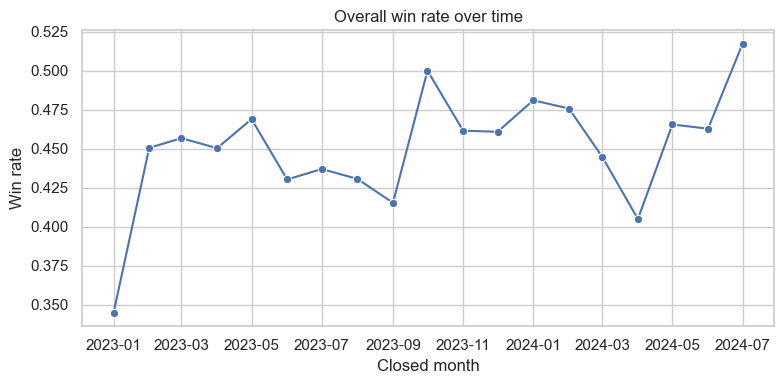

In [2]:
plt.figure(figsize=(8, 4))

df["closed_month"] = df["closed_date"].dt.to_period("M").dt.to_timestamp()
monthly_wr = (
    df.groupby("closed_month")["wonflag"]
      .mean()
      .reset_index(name="winrate")
)

sns.lineplot(data=monthly_wr, x="closed_month", y="winrate", marker="o")
plt.title("Overall win rate over time")
plt.xlabel("Closed month")
plt.ylabel("Win rate")
plt.tight_layout()
plt.show()


In [3]:
segmentcolsdriver = ["industry", "region", "lead_source"]

driver = (
    df.groupby(segmentcolsdriver)
      .agg(
          deals=("wonflag", "size"),
          winrate=("wonflag", "mean"),
          avgamount=("deal_amount", "mean"),
      )
      .reset_index()
)

driver["liftvsbaseline"] = driver["winrate"] - baselinewr
driver["driverscore"] = driver["winrate"] * driver["avgamount"]

driversorted = driver.sort_values("driverscore", ascending=False)

print("Top 10 driver segments")
driversorted.head(10)


Top 10 driver segments


,industry,region,lead_source,deals,winrate,avgamount,liftvsbaseline,driverscore
44,FinTech,North America,Inbound,59,0.610169,30933.474576,0.157569,18874.662453
21,EdTech,Europe,Outbound,65,0.569231,31552.738462,0.116631,17960.789586
37,FinTech,Europe,Outbound,44,0.568182,29474.954545,0.115582,16747.133264
75,SaaS,India,Referral,51,0.509804,31112.745098,0.057204,15861.399462
65,SaaS,APAC,Outbound,56,0.464286,34042.625000,0.011686,15805.504464
34,FinTech,APAC,Partner,63,0.523810,29630.746032,0.071210,15520.866969
0,Ecommerce,APAC,Inbound,65,0.492308,31295.600000,0.039708,15407.064615
31,EdTech,North America,Referral,69,0.536232,28040.159420,0.083632,15036.027515
27,EdTech,India,Referral,56,0.535714,28031.410714,0.083114,15016.827168
23,EdTech,Europe,Referral,67,0.447761,33512.955224,-0.004839,15005.800847


### 1.1 Segment driver view (industry, region, lead source)

Using historical outcomes, we compute a segment table by `(industry, region, lead_source)` with:
- `deals`: number of deals in the segment  
- `winrate`: average `won_flag` (win rate)  
- `avgamount`: average deal amount  
- `liftvsbaseline`: win rate minus baseline win rate  
- `driverscore`: winrate × avgamount, approximating expected revenue quality for that segment

> **Result:** Use the printed table to identify top segments like **FinTech / North America / Inbound**, which show high lift and driverscore.

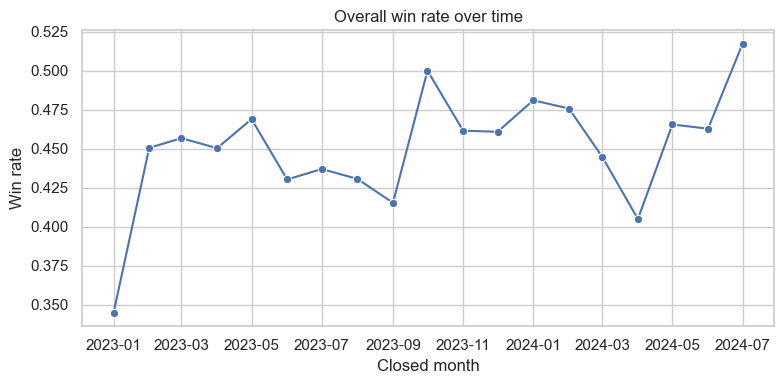

In [4]:
plt.figure(figsize=(8, 4))

df["closed_month"] = df["closed_date"].dt.to_period("M").dt.to_timestamp()
monthly_wr = (
    df.groupby("closed_month")["wonflag"]
      .mean()
      .reset_index(name="winrate")
)

sns.lineplot(data=monthly_wr, x="closed_month", y="winrate", marker="o")
plt.title("Overall win rate over time")
plt.xlabel("Closed month")
plt.ylabel("Win rate")
plt.tight_layout()
plt.show()


Emerging high-value driver alerts
ALERT EMERGING DRIVER FinTech North America via Inbound win rate 61.0% on 59 deals, avg deal 30933 lift vs baseline 15.8%.
ALERT EMERGING DRIVER EdTech Europe via Outbound win rate 56.9% on 65 deals, avg deal 31553 lift vs baseline 11.7%.
ALERT EMERGING DRIVER FinTech Europe via Outbound win rate 56.8% on 44 deals, avg deal 29475 lift vs baseline 11.6%.
ALERT EMERGING DRIVER SaaS India via Referral win rate 51.0% on 51 deals, avg deal 31113 lift vs baseline 5.7%.
ALERT EMERGING DRIVER FinTech APAC via Partner win rate 52.4% on 63 deals, avg deal 29631 lift vs baseline 7.1%.


,industry,region,lead_source,deals,winrate,avgamount,liftvsbaseline,driverscore
44,FinTech,North America,Inbound,59,0.610169,30933.474576,0.157569,18874.662453
21,EdTech,Europe,Outbound,65,0.569231,31552.738462,0.116631,17960.789586
37,FinTech,Europe,Outbound,44,0.568182,29474.954545,0.115582,16747.133264
75,SaaS,India,Referral,51,0.509804,31112.745098,0.057204,15861.399462
34,FinTech,APAC,Partner,63,0.523810,29630.746032,0.071210,15520.866969


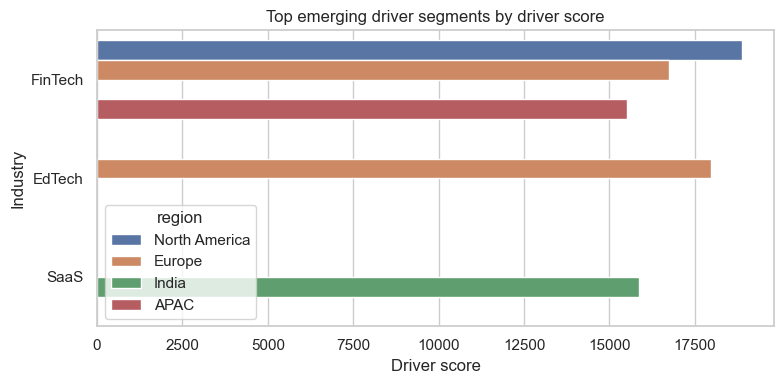

In [5]:
# Alert 2 – Emerging high-value driver segments

mindealsdriver = 40
liftthreshold = 0.05   # 5 points above baseline
topn = 5

topemerging = (
    driver
    .query("deals >= @mindealsdriver and liftvsbaseline >= @liftthreshold")
    .sort_values("driverscore", ascending=False)
    .head(topn)
)

print("Emerging high-value driver alerts")
if topemerging.empty:
    print("None triggered with current thresholds.")
else:
    for _, row in topemerging.iterrows():
        print(
            f"ALERT EMERGING DRIVER {row['industry']} {row['region']} via {row['lead_source']} "
            f"win rate {row['winrate']:.1%} on {int(row['deals'])} deals, "
            f"avg deal {row['avgamount']:.0f} lift vs baseline {row['liftvsbaseline']:.1%}."
        )

display(topemerging)

# Visual for emerging drivers
plt.figure(figsize=(8, 4))
sns.barplot(
    data=topemerging,
    x="driverscore",
    y="industry",
    hue="region",
    orient="h"
)
plt.title("Top emerging driver segments by driver score")
plt.xlabel("Driver score")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()


## 2. Stage-aware win probabilities and risk bands

To move from static analysis to a **deal-level engine**, we estimate win probabilities by segment and stage: 
- Group by `(industry, region, lead_source, deal_stage)` to get `winrate` for each segment-stage.  
- Join this back to each deal as `seg_win_prob` and bucket into `risk_band` (high/medium/low risk based on probability thresholds).


In [6]:
# Segment rules with deal_stage
segmentcolsrules = ["industry", "region", "lead_source", "deal_stage"]

segrules = (
    df.groupby(segmentcolsrules)
      .agg(
          deals=("wonflag", "size"),
          winrate=("wonflag", "mean"),
      )
      .reset_index()
      .rename(columns={"winrate": "seg_win_prob"})
)

print("Sample of segment rules win probabilities")
segrules.head()

# Score each deal
dfscored = df.merge(segrules, on=segmentcolsrules, how="left")

dfscored["seg_win_prob"] = dfscored["seg_win_prob"].fillna(baselinewr)

def riskband(p, baseline=baselinewr, delta=0.05):
    if p >= baseline + delta:
        return "low_risk_high_fit"
    elif p <= baseline - delta:
        return "high_risk_low_fit"
    else:
        return "medium_risk"

dfscored["risk_band"] = dfscored["seg_win_prob"].apply(riskband)

dfscored[["deal_id", "industry", "region", "lead_source", "deal_stage",
          "seg_win_prob", "risk_band"]].head()


Sample of segment rules win probabilities


,deal_id,industry,region,lead_source,deal_stage,seg_win_prob,risk_band
0,D00001,SaaS,North America,Referral,Qualified,0.500000,medium_risk
1,D00002,SaaS,India,Referral,Closed,0.888889,low_risk_high_fit
2,D00003,HealthTech,APAC,Inbound,Proposal,0.500000,medium_risk
3,D00004,FinTech,India,Partner,Negotiation,0.416667,medium_risk
4,D00005,HealthTech,APAC,Outbound,Qualified,0.416667,medium_risk


### 2.1 Example deal-level output

The sample above shows, for each deal, its **segment win probability** and **risk band**. 
Sales leaders can use this to quickly spot **high-risk** deals in strategic segments and prioritize coaching or exec support.


In [7]:
# Alert 3 – Pipeline skewed toward low-fit segments

openpipeline = dfscored.copy()  # demo: treat all as open

totalvalue = openpipeline["deal_amount"].sum()
lowfitvalue = openpipeline.loc[
    openpipeline["risk_band"] == "high_risk_low_fit", "deal_amount"
].sum()

lowfitshare = lowfitvalue / totalvalue if totalvalue > 0 else 0.0
thresholdlowfitshare = 0.4  # 40%

print("Pipeline composition alert")
if lowfitshare >= thresholdlowfitshare:
    print(
        f"ALERT PIPELINE LOW-FIT SKEW: "
        f"{lowfitshare:.1%} of pipeline value is in low-fit segments "
        f"(threshold {thresholdlowfitshare:.0%})."
    )
else:
    print(
        f"No alert: low-fit segments account for {lowfitshare:.1%} of pipeline value "
        f"(threshold {thresholdlowfitshare:.0%})."
    )



Pipeline composition alert
No alert: low-fit segments account for 36.0% of pipeline value (threshold 40%).


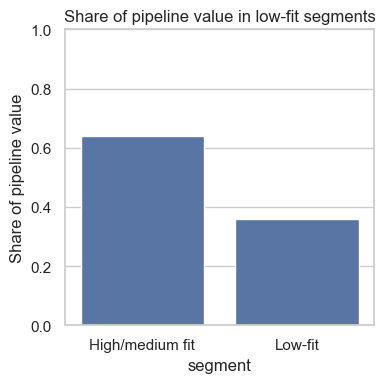

In [8]:
# Visual: share of value in low-fit vs other
share_df = pd.DataFrame({
    "segment": ["High/medium fit", "Low-fit"],
    "value_share": [1 - lowfitshare, lowfitshare],
})

plt.figure(figsize=(4, 4))
sns.barplot(data=share_df, x="segment", y="value_share")
plt.title("Share of pipeline value in low-fit segments")
plt.ylabel("Share of pipeline value")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## 3. Stalled pipeline detection

We flag **stalled deals** based on age in stage (e.g., age_days > 60 and not Closed) and then aggregate stalled volume by `(industry, region, deal_stage)`.
This highlights where pipeline is getting stuck and how much value is at risk.


In [9]:
# Alert 4 – Stage stalling by segment

# Use closed deals to learn typical sales_cycle_days by industry, region, deal_stage
closed = dfscored.copy()  # if you had an 'open' flag you could filter; for demo use all

stallsegmentcols = ["industry", "region", "deal_stage"]

segcycle = (
    closed.groupby(stallsegmentcols)["sales_cycle_days"]
          .agg("median")
          .rename("median_cycle")
          .reset_index()
)

# Join median cycle back to open pipeline
openpipeline = openpipeline.merge(segcycle, on=stallsegmentcols, how="left")

margindays = 15

openpipeline["is_stalled"] = (
    (openpipeline["sales_cycle_days"] > openpipeline["median_cycle"] + margindays)
    & openpipeline["median_cycle"].notna()
)

stallsummary = (
    openpipeline.loc[openpipeline["is_stalled"]]
    .groupby(stallsegmentcols)
    .agg(
        stalled_deals=("deal_id", "size"),
        stalled_value=("deal_amount", "sum"),
    )
    .reset_index()
)

minstalleddeals = 10

print("Stage stalling alerts")
stallfiltered = stallsummary.query("stalled_deals >= @minstalleddeals")
if stallfiltered.empty:
    print("None triggered with current thresholds.")
else:
    for _, row in stallfiltered.iterrows():
        print(
            f"ALERT STALLING {row['industry']} {row['region']} at stage {row['deal_stage']}: "
            f"{int(row['stalled_deals'])} stalled deals worth {row['stalled_value']:.0f}. "
            f"Deals are beyond median cycle by {margindays} days."
        )


Stage stalling alerts
ALERT STALLING Ecommerce APAC at stage Closed: 18 stalled deals worth 476443. Deals are beyond median cycle by 15 days.
ALERT STALLING Ecommerce APAC at stage Demo: 19 stalled deals worth 589242. Deals are beyond median cycle by 15 days.
ALERT STALLING Ecommerce APAC at stage Negotiation: 18 stalled deals worth 514246. Deals are beyond median cycle by 15 days.
ALERT STALLING Ecommerce APAC at stage Proposal: 18 stalled deals worth 376871. Deals are beyond median cycle by 15 days.
ALERT STALLING Ecommerce APAC at stage Qualified: 17 stalled deals worth 433969. Deals are beyond median cycle by 15 days.
ALERT STALLING Ecommerce Europe at stage Closed: 14 stalled deals worth 331007. Deals are beyond median cycle by 15 days.
ALERT STALLING Ecommerce Europe at stage Demo: 19 stalled deals worth 625217. Deals are beyond median cycle by 15 days.
ALERT STALLING Ecommerce Europe at stage Negotiation: 14 stalled deals worth 488512. Deals are beyond median cycle by 15 days.
A

### 3.1 Stalled pockets

The stalled summary table shows, for each industry, region, and stage, the count of stalled deals and the total stalled value.  
These pockets are ideal targets for pipeline reviews, stricter stage criteria, or executive outreach.

To make this system actionable, we convert the computed insights into structured **alerts** that can be emailed, sent to Slack, or shown in a dashboard. 
Each alert record includes an `alert_type`, `severity`, relevant segment or deal identifiers, and a human-readable message.
Example alerts :

`alerts_df` contains high-performing segment alerts, stalled-pipeline alerts, and high-risk deal alerts with clear, human-readable messages.
In a production SkyGeni system, this table would feed a notification service and a lightweight web UI.


In [10]:
display(stallfiltered.head())

,industry,region,deal_stage,stalled_deals,stalled_value
0,Ecommerce,APAC,Closed,18,476443
1,Ecommerce,APAC,Demo,19,589242
2,Ecommerce,APAC,Negotiation,18,514246
3,Ecommerce,APAC,Proposal,18,376871
4,Ecommerce,APAC,Qualified,17,433969


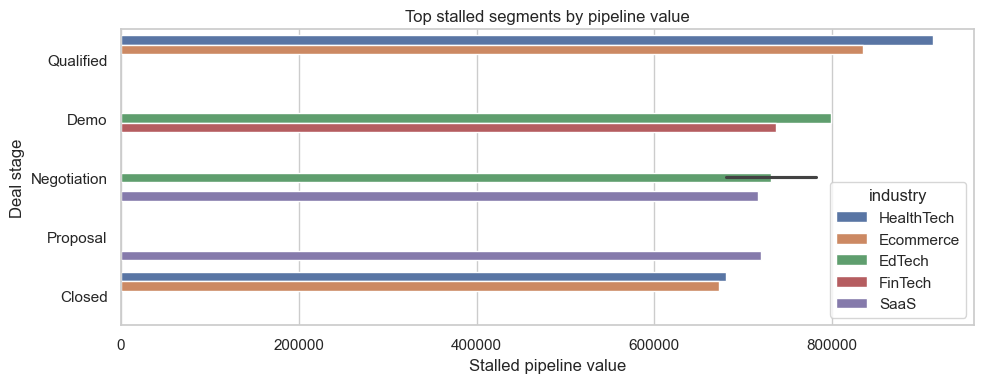

In [11]:
# Visual: top stalled segments by pipeline value
stall_plot = (
    stallsummary
    .sort_values("stalled_value", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=stall_plot,
    x="stalled_value",
    y="deal_stage",
    hue="industry",
    orient="h"
)
plt.title("Top stalled segments by pipeline value")
plt.xlabel("Stalled pipeline value")
plt.ylabel("Deal stage")
plt.tight_layout()
plt.show()


## 5. System view and limitations

**How it would run in production** 
- A daily batch job loads fresh CRM data into the warehouse, recomputes segment drivers, risk bands, and stalled metrics, and refreshes `alerts_df`.
- A small service or scheduled script sends email/Slack digests and powers a simple dashboard for sales leaders.

**Key limitations**
- Data quality issues (wrong stages, missing dates) can distort win rates and stalled flags.
- Sparse segments produce noisy estimates; alerts on very small segments should be treated cautiously.  
- The system is intentionally **rules-based and interpretable**; it should complement, not replace, more advanced modeling and human judgment.
